In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [5]:
N = 500

def real_model(x):
    y = (torch.randn(1, N) + 2) * x + 3 + torch.randn(1, N)
    return y

x = torch.linspace(-3, 4, N).view(-1, 1)
y = real_model(x.squeeze()).view(-1, 1)

In [3]:
class NormalModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.mean = None
        self.std = None

        k = 6

        self.hidden_layers = torch.nn.Sequential(
            torch.nn.Linear(1, k),
            torch.nn.ReLU(),
            torch.nn.Linear(k, k)
        )
        self.mean_layer = torch.nn.Linear(k, 1)
        self.std_layer = torch.nn.Sequential(
            torch.nn.Sigmoid(),
            torch.nn.Linear(k, 1),
            torch.nn.ELU()
        )

    def forward(self, x):
        h = self.hidden_layers(x)
        self.mean = self.mean_layer(h)
        self.std = self.std_layer(h) + 1

        return self.mean, self.std
    
    def __repr__(self):
        return f'Mean: {self.mean.item():.5f} and Std: {self.std.item():.5f}'


In [4]:
def k(mean, std, x):
    return 1 / np.sqrt(2 * np.pi) * torch.exp(-((x - mean)/std) ** 2 / 2) / std

def log_k(mean, std, y):
    return -torch.log(std) - (y - mean)**2 / (2 * std**2)

In [5]:
model = NormalModel()
opt = torch.optim.Adam(model.parameters(), lr=0.01)

In [6]:
max_epoch = 5000
for epoch in range(max_epoch):
    opt.zero_grad()

    if epoch % 10 == 0 and max_epoch - epoch > 100:
        sample = torch.randint(N, (1, 100)).squeeze()
    elif max_epoch - epoch == 100:
        sample = torch.arange(0, N)

    mean, std = model(x[sample])
    log_likelyhood = log_k(mean, std, y[sample]).sum()
    loss = -log_likelyhood
    loss.backward()
    opt.step()

    if epoch % 100 == 0:
        print(f'{epoch}:: Loss = {loss.item()}')
    


0:: Loss = 2224.391357421875
100:: Loss = 141.83145141601562
200:: Loss = 135.4949493408203
300:: Loss = 127.71595001220703
400:: Loss = 128.5430908203125
500:: Loss = 123.4670181274414
600:: Loss = 126.12088775634766
700:: Loss = 146.6477813720703
800:: Loss = 145.50584411621094
900:: Loss = 124.53524780273438
1000:: Loss = 120.84677124023438
1100:: Loss = 110.33358764648438
1200:: Loss = 124.85301208496094
1300:: Loss = 117.82779693603516
1400:: Loss = 138.0464324951172
1500:: Loss = 116.53793334960938
1600:: Loss = 99.43482971191406
1700:: Loss = 109.64029693603516
1800:: Loss = 110.78255462646484
1900:: Loss = 122.58317565917969
2000:: Loss = 120.83924865722656
2100:: Loss = 126.49026489257812
2200:: Loss = 108.84772491455078
2300:: Loss = 110.89714813232422
2400:: Loss = 108.93376922607422
2500:: Loss = 104.9080581665039
2600:: Loss = 122.94877624511719
2700:: Loss = 116.86419677734375
2800:: Loss = 138.53990173339844
2900:: Loss = 112.27103424072266
3000:: Loss = 118.131591796875

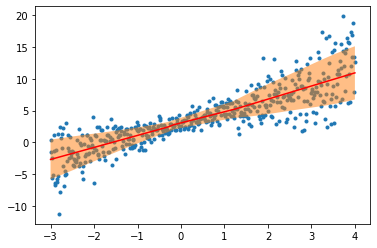

In [7]:
m, s = model(x)

plt.scatter(x, y, marker='.')
plt.plot(x, m.detach(), 'r')
plt.fill_between(x.squeeze(), (m.detach()-s.detach()).squeeze(), (m.detach()+s.detach()).squeeze(), alpha=0.5)

In [8]:
x.size(), y.size()

(torch.Size([500, 1]), torch.Size([500, 1]))

In [9]:
def check_within_two_stddeviations(x, y):
    y_pred, y_std = model(x)
    # want 95.4% inside 
    a = (y - y_pred).abs() / y_std
    hits = (a <= 2).sum()
    return hits / len(x)

In [10]:
check_within_two_stddeviations(x, y) - 0.954

tensor(0.0080)

In [11]:
np.sqrt(0.96 * 0.04 / N)

0.008763560920082658

---
# using polynomial functions

In [17]:
def eval_powers_of_x(x, n):
    return x.pow(torch.arange(n))

In [56]:
class NormalPolynomialModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.mean = None
        self.std = None
        
        self.N_mean = 2 # constant, linear, quadratic, ... terms
        self.N_var = 3

        self.poly_multipliers_mean = torch.nn.parameter.Parameter(torch.rand(self.N_mean))
        self.poly_multipliers_var = torch.nn.parameter.Parameter(torch.rand(self.N_var))
        self.var_shift = torch.nn.parameter.Parameter(torch.tensor(0.1))

        self.mean_layer = torch.nn.Linear(self.N_mean, 1)
        self.var_layer = torch.nn.Sequential(
            torch.nn.Linear(self.N_var, 1),
            torch.nn.ReLU()
        )
    
    def forward(self, x):
        self.mean = self.mean_layer(self.poly_multipliers_mean * eval_powers_of_x(x, self.N_mean))
        self.var = self.var_layer(self.poly_multipliers_var * eval_powers_of_x(x, self.N_var)) + self.var_shift ** 2
        return self.mean, self.var
    


In [57]:
def log_k_with_var(mean, var, y):
    return -0.5*torch.log(var) - (y - mean)**2 / (2 * var)

In [67]:
model = NormalPolynomialModel()
opt = torch.optim.Adam(model.parameters())

max_epoch = 10000
for epoch in range(max_epoch):
    opt.zero_grad()

    # if we want to use a little bit of randomness in our decent
    # (could possibly avoid local minimums?),
    # index x and y by sample below
    if epoch % 10 == 0 and max_epoch - epoch > 50:
        sample = torch.randint(N, (1, 250)).squeeze()
    elif max_epoch - epoch == 100:
        sample = torch.arange(0, N)

    mean, var = model(x[sample])
    log_likelyhood = log_k_with_var(mean, var, y[sample]).sum()
    loss = -log_likelyhood
    loss.backward()
    opt.step()

    if epoch % 100 == 0:
        print(f'{epoch}:: Loss = {loss.item()}')
    

0:: Loss = 405398.125
100:: Loss = 163619.140625
200:: Loss = 75454.6875
300:: Loss = 55852.0703125
400:: Loss = 50508.296875
500:: Loss = 5876.630859375
600:: Loss = 2437.30712890625
700:: Loss = 2006.72607421875
800:: Loss = 2050.883056640625
900:: Loss = 1542.2718505859375
1000:: Loss = 1606.607666015625
1100:: Loss = 1350.631103515625
1200:: Loss = 1475.6956787109375
1300:: Loss = 1423.88330078125
1400:: Loss = 1307.236572265625
1500:: Loss = 1040.457275390625
1600:: Loss = 1180.1156005859375
1700:: Loss = 1114.2218017578125
1800:: Loss = 1110.2315673828125
1900:: Loss = 1035.614013671875
2000:: Loss = 958.4446411132812
2100:: Loss = 850.5654296875
2200:: Loss = 886.35498046875
2300:: Loss = 1028.785400390625
2400:: Loss = 810.1786499023438
2500:: Loss = 940.7409057617188
2600:: Loss = 812.9126586914062
2700:: Loss = 713.69921875
2800:: Loss = 686.7169799804688
2900:: Loss = 771.6331787109375
3000:: Loss = 706.4974365234375
3100:: Loss = 668.2977905273438
3200:: Loss = 724.25689697

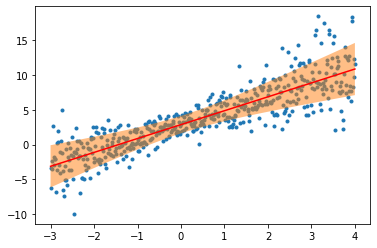

In [68]:
m, var = model(x)
s = var.sqrt()

plt.scatter(x, y, marker='.')
plt.plot(x, m.detach(), 'r')
plt.fill_between(x.squeeze(), (m.detach()-s.detach()).squeeze(), (m.detach()+s.detach()).squeeze(), alpha=0.5)